In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from matplotlib import pyplot
import seaborn as sns

# hyperparameters turning
from ray import tune, train, ray
from ray.tune.schedulers import ASHAScheduler
ray.init(log_to_driver=False)

#Plotting 
from pandas.plotting import scatter_matrix

#Libraries for Statistical Models
import statsmodels.api as sm

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

_TARGET_STK = 'MSFT'
pd.options.display.max_columns = None
pd.options.display.expand_frame_repr = False

2024-01-23 12:11:14,241	INFO worker.py:1724 -- Started a local Ray instance.


In [2]:
from datetime import datetime
import yfinance as yfin

# Loading the data
stk_tickers = [_TARGET_STK, 'AMD', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['VIXCLS', 'SP500', 'DJIA']

start = datetime(2014, 1, 1)
end = datetime(2023, 12, 31)
# stk_data = web.get_data_yahoo(stk_tickers, start, end)
stk_data = yfin.download(stk_tickers, start, end).dropna()
ccy_data = web.DataReader(ccy_tickers, 'fred', start, end).dropna()
idx_data = web.DataReader(idx_tickers, 'fred', start, end).dropna()

print(stk_data)
print(ccy_data)
print(idx_data)

[*********************100%%**********************]  3 of 3 completed
             Adj Close                               Close                                High                                 Low                                Open                            Volume                     
                   AMD       GOOGL        MSFT         AMD       GOOGL        MSFT         AMD       GOOGL        MSFT         AMD       GOOGL        MSFT         AMD       GOOGL        MSFT       AMD      GOOGL      MSFT
Date                                                                                                                                                                                                                         
2014-01-02    3.950000   27.855856   31.290813    3.950000   27.855856   37.160000    3.980000   27.971722   37.400002    3.840000   27.734234   37.099998    3.850000   27.914413   37.349998  20548400   72783144  30632200
2014-01-03    4.000000   27.652653   31.080

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
validation_size = 0.2
epoch_num = 200
batch_size = 32
log_dir = f'runs/{_TARGET_STK}'

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
class LSTMDataSet(Dataset):
    def __init__(self, X, Y, seq_len, features):
        self.X = X
        self.Y = Y
        self.seq_len = seq_len
        self.features = features
    def __len__(self):
        return len(self.X) - self.seq_len + 1
    
    def __getitem__(self, idx):
        return (torch.tensor(np.array(self.X[idx: idx + self.seq_len].loc[:, self.features]), dtype=torch.float32),
                torch.tensor(np.array(self.Y.iloc[idx + self.seq_len - 1,:]), dtype=torch.float32))


In [32]:
from torch import nn
class StockPricePredictionLSTM(nn.Module):
    def __init__(self, seq_len, input_size, hidden_size, num_layers, num_fc_layers, activation_type):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        """
            input_size    : The number of expected features in the input x
            hidden_size   : The number of features in the hidden state h
            num_layers    : Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1
            bias          : If False, then the layer does not use bias weights b_ih and b_hh. Default: True
            batch_first   : If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False
            dropout       : If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0
            bidirectional : If True, becomes a bidirectional LSTM. Default: False
            proj_size     : If > 0, will use LSTM with projections of corresponding size. Default: 0
        """
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        layers = []
        in_features = self.hidden_size
        for i in range(1, num_fc_layers):
            out_features = int(in_features / 2)
            if (out_features <= 1):
                break
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU() if activation_type == 1 else
                          nn.Sigmoid()) if activation_type == 2 else nn.Tanh()
            in_features = out_features

        layers.append(nn.Linear(in_features, 1))
        self.fc = nn.Sequential(*layers)
        self.fc.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            initrange = 0.5
            nn.init.uniform_(m.weight, -initrange, initrange)
            nn.init.zeros_(m.bias)
            # print(f"{m.in_features},{m.out_features}")

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        out, (h_out, _) = self.rnn(x, (h_0, c_0))

        fc_input = h_out[-1].view(-1, self.hidden_size)
        return self.fc(fc_input)


In [6]:
import math 
from sklearn.metrics import mean_squared_error

def eval_dl_method(model, dl, criterion=None, device=device):
    model.eval()
    y_gt = []
    y_pred = []
    vloss = 0.0
    for i, (x, y) in enumerate(dl):
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        if criterion != None:
            vloss += criterion(outputs, y).item()
        # print(f"{i}:{vloss}")
        y_gt.extend(y.cpu().detach().numpy().reshape(-1))
        y_pred.extend(outputs.cpu().detach().numpy().reshape(-1))
    
    return (math.sqrt(mean_squared_error(y_gt, y_pred)) if np.isnan(y_pred).any() == False else 9999, y_gt, y_pred, vloss)

In [44]:
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn_pandas import DataFrameMapper


def gen_analysis_data(stock_name, return_period):
    import pandas_ta
    data = stk_data.xs(stock_name, axis=1, level=1)
    
    data = pd.concat([data.ta.percent_return(length=return_period, prefix=stock_name),
                        data.ta.adosc(prefix=stock_name),
                        data.ta.kvo(prefix=stock_name), 
                        data.ta.rsi(close='Adj Close', length=10, prefix=stock_name)/100,
                        data.ta.rsi(close='Adj Close', length=30, prefix=stock_name)/100,
                        data.ta.rsi(close='Adj Close', length=200, prefix=stock_name)/100,
                        data.ta.stoch(k=10, prefix=stock_name)/100,
                        data.ta.stoch(k=30, prefix=stock_name)/100,
                        data.ta.stoch(k=200, prefix=stock_name)/100],
                        axis=1)
    data = data.dropna().astype('float32')
    return data

def prepare_dataloader(return_period, seq_len):
    Target_Data = gen_analysis_data(_TARGET_STK, return_period)
    GOOGL_Data = gen_analysis_data('GOOGL', return_period)
    AMD_Data = gen_analysis_data('AMD', return_period)

    X1 = pd.concat([Target_Data, GOOGL_Data, AMD_Data], axis=1)

    X2 = ccy_data.pct_change(return_period).dropna()
    X2 = X2.rename(columns={ column : f"{column}_PCTRET_{return_period}" for column in X2.columns.to_list()})

    X3 = pd.concat([idx_data['SP500'].pct_change(return_period), idx_data['DJIA'].pct_change(return_period)], axis=1)
    X3 = X3.rename(columns={ column : f"{column}_PCTRET_{return_period}" for column in X3.columns.to_list()})
    X3 = pd.concat([idx_data['VIXCLS'], X3], axis=1).dropna()

    X1_X2_X3 = pd.concat([X1, X2, X3], axis=1).dropna()
    features = X1_X2_X3.columns.to_list()

    Y_raw = stk_data.loc[:, ('Adj Close', _TARGET_STK)].to_frame().pct_change(return_period).shift(-return_period).dropna().astype('float32')
    Y_raw.columns = [f"{_TARGET_STK}_pred_{return_period}"]

    dataset = pd.concat([Y_raw, X1_X2_X3], axis=1).dropna()

    X = dataset.loc[:, X1_X2_X3.columns]
    Y = dataset.loc[:, Y_raw.columns]

    train_size = int(len(X) * (1 - validation_size))
    X_train = X.iloc[0:train_size].loc[:,features]
    Y_train = Y.iloc[0:train_size]
    X_test  = X.iloc[train_size - seq_len + 1:len(X)].loc[:, features]
    Y_test  = Y.iloc[train_size - seq_len + 1:len(Y)]

    X_dfm = DataFrameMapper(
        [ ([column], StandardScaler()) for column in X_train.columns.to_list()]
        , input_df=True, df_out=True)
    X_train = X_dfm.fit_transform(X_train)
    X_test = X_dfm.transform(X_test)

    train_loader = DataLoader(LSTMDataSet(X_train, Y_train, seq_len, features), batch_size=batch_size)
    test_loader = DataLoader(LSTMDataSet(X_test, Y_test, seq_len,features), batch_size=batch_size)

    return train_loader, test_loader, features

In [61]:
def save_model(model, config, file_path):
    state = {
        'time': str(datetime.now()),
        'model_state': model.state_dict(),
        'input_size': model.input_size,
        'config': config            
    }
    torch.save(state, file_path)

def load_model(file_path):
    data_dict = torch.load(file_path)
    config = data_dict['config']    
    model = StockPricePredictionLSTM(config['seq_len'], input_size=data_dict['input_size'],
                                     hidden_size=int(config['hidden_size']),num_layers=int(config['num_layers']),
                                     num_fc_layers=int(config['num_fc_layers']), activation_type=int(config['activation_type']))

    model.load_state_dict(data_dict['model_state'])
    return model, config


In [52]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.filterwarnings('ignore')

def do_train(model, optimizer, train_dl, test_dl, id_str, config, writer):
    criterion = torch.nn.MSELoss()

    model_name = f"{log_dir}/{id_str}.pt"
    best_loss = 999999999    
    total_loss = 0.0
    total_vloss = 0.0
    for epoch in tqdm(range(epoch_num)):
        model.train()
        running_loss = 0.0
        
        for i, (x, y) in enumerate(train_dl):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            if loss.item() < best_loss:
                best_loss = loss.item()
                save_model(model, config, model_name)
                # torch.save(model.state_dict(), model_name)

        with torch.no_grad():
            (testScore, test_y_gt, test_y_pred, running_vloss)  = eval_dl_method(model, test_dl, criterion)
            train.report({"mse_score":testScore})
            
        writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : running_loss / len(train_dl), 'Validation' : running_vloss / len(test_dl) },
                            epoch + 1)
        total_loss += running_loss / len(train_dl)
        total_vloss += running_vloss / len(test_dl)

        writer.flush()
        
    return {'Train loss':total_loss/epoch_num, 'Validation loss': total_vloss/epoch_num}

def train_LSTM(config):
    return_period = config["return_period"]
    seq_len = config["seq_len"]
    lr = config["lr"]
    momentum = config["momentum"]
    optim_type = config["optim_type"]
    num_layers = config["num_layers"]
    hidden_size = config["hidden_size"]
    num_fc_layers = config["num_fc_layers"]
    activation_type = config["activation_type"]

    # id_str = f"{return_period}_{seq_len}_{lr}_{momentum}_{optim_type}_{num_layers}_{hidden_size}_{num_fc_layers}_{activation_type}"
    id_str = "_".join(str(v) if v < 1 else f'{v:g}' for v in config.values())
    print(id_str)
    writer = SummaryWriter(f"{log_dir}/{id_str}")    

    train_loader, test_loader, features = prepare_dataloader(return_period, seq_len)
    model = StockPricePredictionLSTM(seq_len, input_size=len(features),
                                     hidden_size=hidden_size,num_layers=num_layers,
                                     num_fc_layers=num_fc_layers, activation_type=activation_type)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) if optim_type == 1 else torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    metric_dict = do_train(model, optimizer, train_loader, test_loader, id_str, config, writer)
    writer.add_hparams(
        config,
        metric_dict
    )
    writer.close()


In [ ]:
time_str = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')
log_dir = f'/mnt/AIWorkSpace/work/fin-ml/runs/{_TARGET_STK}/{time_str}'
config={
    "return_period":5,
    "seq_len":5,
    "lr":0.1,
    "momentum":0.484742,
    "optim_type":2,
    "num_layers":4,
    "hidden_size":128,
    "num_fc_layers":3,
    "activation_type":1
}

train_LSTM(config)

In [53]:
search_space = {
    "return_period": tune.grid_search([3, 5]), #[2,3,5,10]
    "seq_len": tune.grid_search([3, 5]), #[2,3,4,5]
    "lr": tune.grid_search([0.01]), #[0.001, 0.01, 0.1]
    "momentum": tune.uniform(0.1, 0.9),
    "optim_type": tune.grid_search([2]), # [1, 2]
    "num_layers": tune.grid_search([4, 8]), #[1, 2, 4, 8]
    "hidden_size": tune.grid_search([8, 128]), #[8, 16, 32, 64, 128]
    "num_fc_layers": tune.grid_search([1, 3]), #1, 2, 3]),
    "activation_type": tune.grid_search([1, 2]) #, 2, 3])
}

turning_parameters = []
total_configs = 1
for k, v in search_space.items():
    if type(v).__name__ == 'dict' and list(v.keys())[0] == 'grid_search' and len(list(v.values())[0]) > 1:
        turning_parameters.append(k)
        total_configs *= len(list(v.values())[0])
print(turning_parameters)
print(f"Total count of configs = {total_configs}")


['return_period', 'seq_len', 'num_layers', 'hidden_size', 'num_fc_layers', 'activation_type']
Total count of configs = 64


In [54]:
import warnings
warnings.filterwarnings('ignore', category=Warning)

time_str = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')
log_dir = f'/mnt/AIWorkSpace/work/fin-ml/runs/{_TARGET_STK}/{time_str}'

analysis = tune.run(train_LSTM, 
                    config=search_space,
                    resources_per_trial={'cpu':0.125, 'gpu':0.125},
                    metric="mse_score",
                    mode="min")

2024-01-23 13:40:56,868	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Trial name,mse_score
train_LSTM_176aa_00000,0.0322688
train_LSTM_176aa_00001,0.0320121
train_LSTM_176aa_00002,0.0326178
train_LSTM_176aa_00003,0.0322255
train_LSTM_176aa_00004,0.0321182
train_LSTM_176aa_00005,0.0320651
train_LSTM_176aa_00006,0.0407545
train_LSTM_176aa_00007,0.0319938
train_LSTM_176aa_00008,0.0320931
train_LSTM_176aa_00009,0.032112


2024-01-23 14:17:06,369	INFO tune.py:1042 -- Total run time: 2169.50 seconds (2169.46 seconds for the tuning loop).


In [55]:
mse_list = []
trial_list = list(analysis.trial_dataframes.values())
for i, trial in enumerate(trial_list):
    if trial.empty == False:
        d = pd.DataFrame.from_dict({"mse_score": trial.describe().loc['mean', 'mse_score'], "trial_id": trial.loc[0:0,'trial_id'] })
    else:
        d = pd.DataFrame.from_dict({"mse_score": [np.NaN], "trial_id": [np.NaN]})
    mse_list.append(d)
mse_df = pd.concat(mse_list)
mse_df = mse_df.reset_index().loc[:, ["mse_score", "trial_id"]]
print(mse_df)


    mse_score     trial_id
0     0.03227  176aa_00000
1     0.03202  176aa_00001
2     0.03238  176aa_00002
3     0.03193  176aa_00003
4     0.03212  176aa_00004
..        ...          ...
59    0.03919  176aa_00059
60    0.03940  176aa_00060
61    0.03931  176aa_00061
62    0.04212  176aa_00062
63    0.03937  176aa_00063

[64 rows x 2 columns]


In [73]:
import shutil

config_df = pd.DataFrame(analysis.get_all_configs().values())
# print(config_df)
results = pd.concat([mse_df, config_df], axis=1)
# print(results)

sorted_results = results.sort_values(by="mse_score")
# print(sorted_results.head(100))
sorted_results_file = f"{_TARGET_STK}_sorted_results.csv"
sorted_results.to_csv(sorted_results_file)

best_config = config_df.iloc[sorted_results.index[0]].to_dict()
id_str = "_".join(str(v) if v < 1 else f'{v:g}' for v in best_config.values())
best_model_name = f"{log_dir}/{id_str}.pt"
print(best_model_name)
shutil.copy(best_model_name, f"{_TARGET_STK}.pt")

# summary = pd.DataFrame(index=sorted_results.describe().index.values)
# for hperparameter_name in turning_parameters: #['optim_type', 'num_layers', 'hidden_size', 'num_fc_layers', 'activation_type']:
#     parameter_group = sorted_results.groupby(hperparameter_name)
#     for g in parameter_group:
#         summary[f"{hperparameter_name}_{g[0]}"] = g[1].describe()['mse_score']
# print(summary)



/mnt/AIWorkSpace/work/fin-ml/runs/MSFT/2024-01-23_13.40.56/3_3_0.01_0.4233917216152515_2_4_128_1_2.pt


'MSFT.pt'

In [ ]:
s = sorted_results['mse_score'].describe()
print(s)
min_x = s['min'] - s['std']
max_x = s['max'] + s['std']
print(min_x)
print(max_x)


t1 = sorted_results.where(lambda x: x.activation_type == 1).dropna()
t2 = sorted_results.where(lambda x: x.activation_type == 2).dropna()

t1['mse_score'].hist(bins=50, figsize=(12,2))
pyplot.xlim([min_x, max_x])
pyplot.show()
t2['mse_score'].hist(bins=50, figsize=(48,2))
pyplot.xlim([min_x, max_x])
pyplot.show()

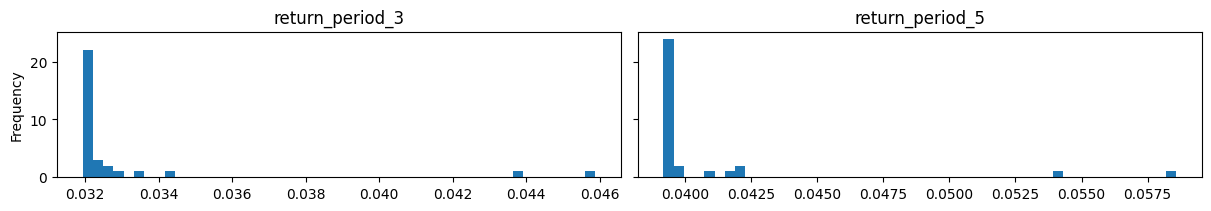

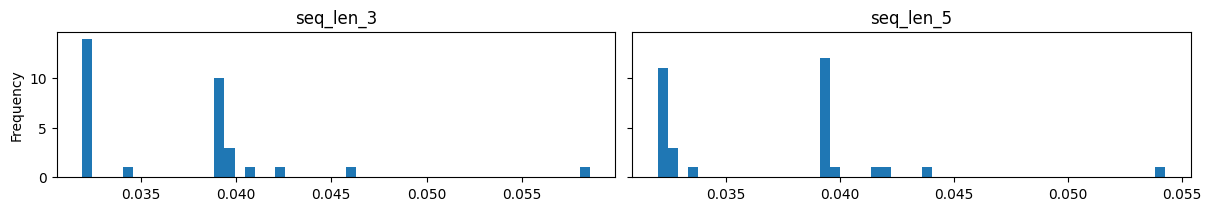

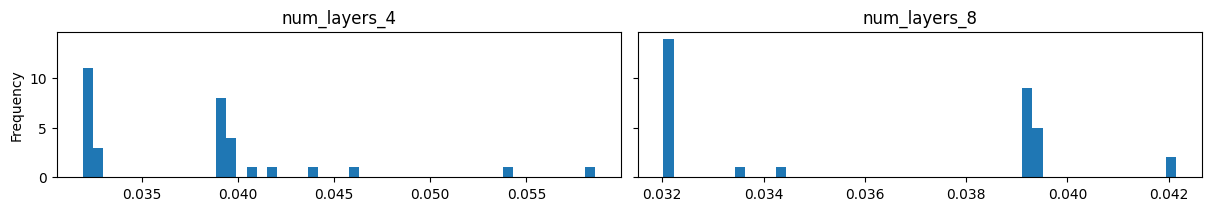

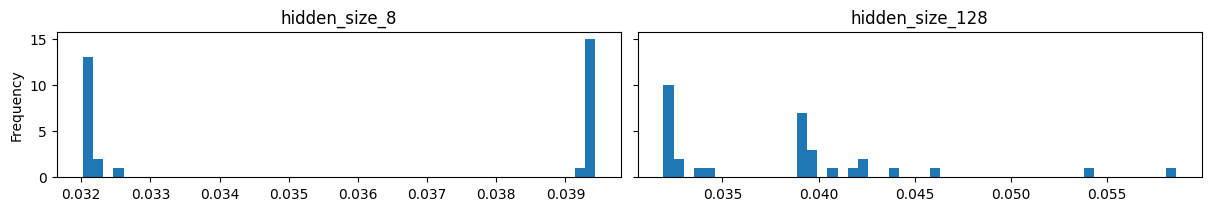

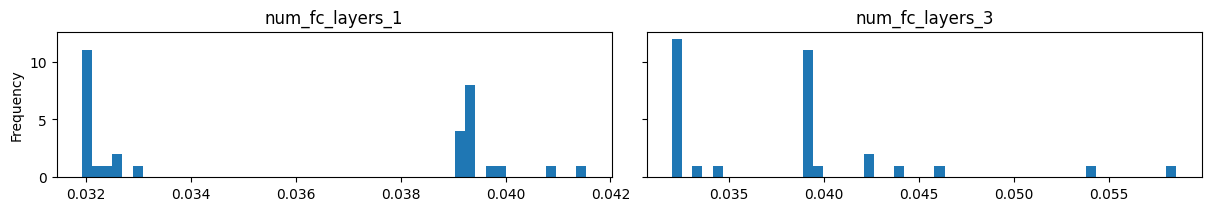

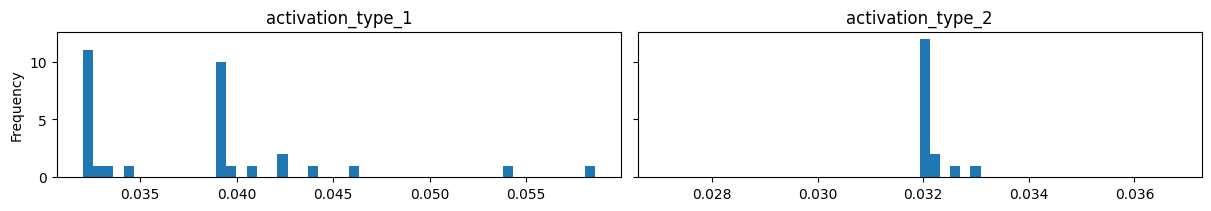

In [74]:
mse_desc = sorted_results['mse_score'].astype('float32').describe()
xlimit_range = [mse_desc['min'] - mse_desc['std'], mse_desc['min'] + mse_desc['std']]
for hperparameter_name in turning_parameters:
    parameter_group = sorted_results.groupby(hperparameter_name)
    fix, axs = pyplot.subplots(1, len(parameter_group), layout='constrained', sharex=False, sharey=True, figsize=(12,2))
    for i, g in enumerate(parameter_group):
        g[1]['mse_score'].astype('float32').plot(kind='hist',bins=50, subplots=True,sharex=False,sharey=True,ax=axs[i])
        axs[i].set_title(f"{hperparameter_name}_{g[0]}")
        
pyplot.xlim(xlimit_range)
pyplot.show()

In [78]:
id_str_of_best = f"5_5_0.01_{best_config.momentum}_{int(best_config.optim_type)}_{int(best_config.num_layers)}_{int(best_config.hidden_size)}_{int(best_config.num_fc_layers)}_{int(best_config.activation_type)}"
best_model_name = f"{log_dir}/{id_str_of_best}.pt"
print(best_model_name)

/mnt/AIWorkSpace/work/fin-ml/runs/NVDA/2024-01-23_08.52.09/5_5_0.01_0.5908189740341324_2_4_16_3_1.pt


In [57]:
sorted_results_file = f"{_TARGET_STK}_sorted_results.csv"
sorted_results = pd.read_csv(sorted_results_file, dtype='str')
best_config = sorted_results.loc[0]
print(best_config)
# id_str_of_best = f"5_5_0.01_{best_config.momentum}_{best_config.optim_type}_{best_config.num_layers}_{best_config.hidden_size}_{best_config.num_fc_layers}_{best_config.activation_type}"
# best_model_name = f"/mnt/AIWorkSpace/work/fin-ml/runs/{_TARGET_STK}/{time_str}/{id_str_of_best}.pt"
# print(best_model_name)

Unnamed: 0                            3
mse_score          0.031932301874907566
trial_id                    176aa_00003
return_period                         3
seq_len                               3
lr                                 0.01
momentum             0.4233917216152515
optim_type                            2
num_layers                            4
hidden_size                         128
num_fc_layers                         1
activation_type                       2
Name: 0, dtype: object


       optim_type_1  optim_type_2  num_layers_1  num_layers_2  num_layers_4  num_layers_8  hidden_size_8  hidden_size_16  hidden_size_32  hidden_size_64  hidden_size_128  num_fc_layers_1  num_fc_layers_2  num_fc_layers_3  activation_type_1  activation_type_2  activation_type_3
count     180.00000     180.00000      90.00000      90.00000      90.00000      90.00000       72.00000        72.00000        72.00000        72.00000         72.00000        120.00000        120.00000        120.00000          120.00000          120.00000          120.00000
mean        0.05050       0.04198       0.04958       0.04611       0.04557       0.04371        0.04494         0.04569         0.04613         0.04600          0.04845          0.04670          0.04617          0.04586            0.04623            0.04625            0.04625
std         0.00472       0.00550       0.00643       0.00577       0.00724       0.00582        0.00637         0.00657         0.00608         0.00554          0.00

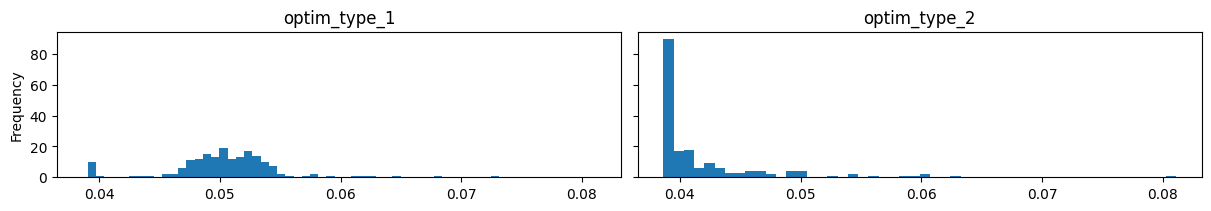

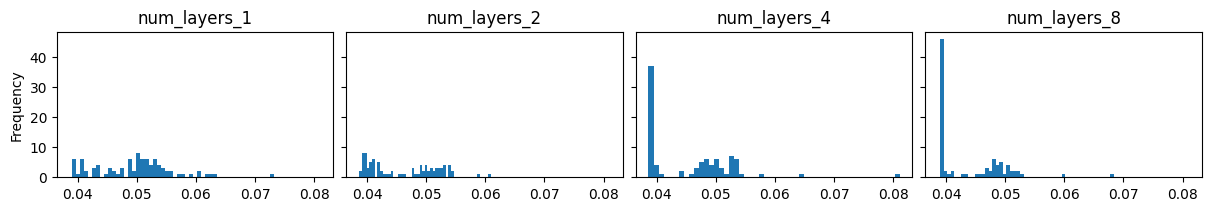

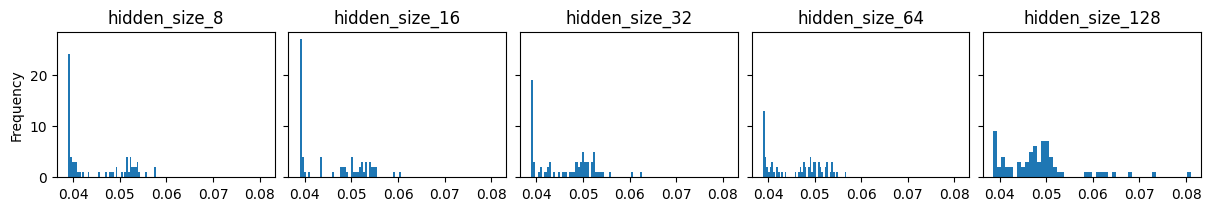

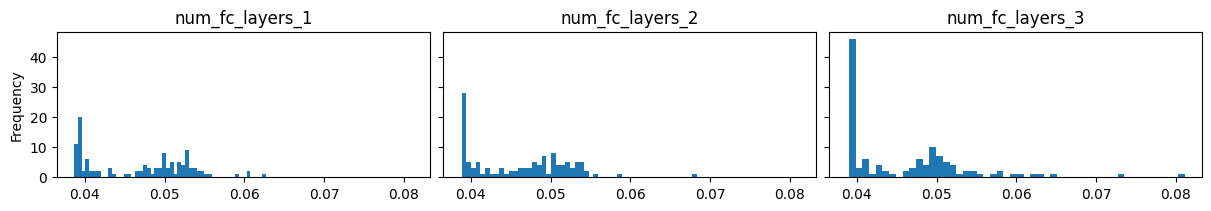

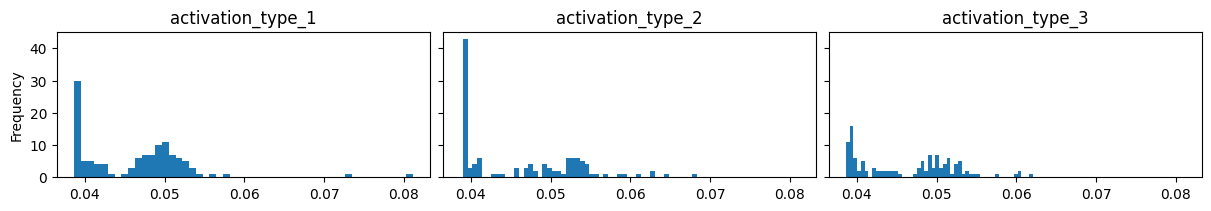

In [50]:
pd.options.display.float_format = '{:.5f}'.format
sorted_results = pd.read_csv('2024-01-19_21.52.54_sorted_results.csv')
summary = pd.DataFrame(index=sorted_results.describe().index.values)
for hperparameter_name in ['optim_type', 'num_layers', 'hidden_size', 'num_fc_layers', 'activation_type']:
    parameter_group = sorted_results.groupby(hperparameter_name)
    for g in parameter_group:
        summary[f"{hperparameter_name}_{g[0]}"] = g[1].describe()['mse_score']
print(summary)

for hperparameter_name in ['optim_type', 'num_layers', 'hidden_size', 'num_fc_layers', 'activation_type']:
    parameter_group = sorted_results.groupby(hperparameter_name)
    fix, axs = pyplot.subplots(1, len(parameter_group), layout='constrained', sharex=True, sharey=True, figsize=(12,2))
    for i, g in enumerate(parameter_group):
        g[1]['mse_score'].plot(kind='hist',bins=50, subplots=True,sharex=True,sharey=True,ax=axs[i])
        axs[i].set_title(f"{hperparameter_name}_{g[0]}")
    pyplot.show()     



In [62]:
import math 
from sklearn.metrics import mean_squared_error

pd.set_option('display.precision', 5)

model, config = load_model(f"{_TARGET_STK}.pt")
model.to(device)

train_loader, test_loader, features = prepare_dataloader(config["return_period"], config["seq_len"])
model.eval()

(trainScore, train_y_gt, train_y_pred, _)= eval_dl_method(model, train_loader, device=device)
(testScore, test_y_gt, test_y_pred, _)  = eval_dl_method(model, test_loader, device=device)
print(test_y_pred)
print(f"Train RMSE: {trainScore:.2f}\nTest RMSE: {testScore:.2f}")


[0.006565256, 0.0025816008, 0.001620515, 0.002517468, 0.00456472, 0.00501399, 0.0073618935, 0.010441058, 0.012019502, 0.009089329, 0.005561142, 0.0059482204, 0.0071649095, 0.0069134934, 0.0036523815, 0.0011810462, 0.000117602525, -7.1499962e-06, 0.00092655304, 0.001009953, 0.0016335535, 0.00038729399, 0.0002855619, -0.00019563851, 0.0007598947, 0.002777877, 0.004017937, 0.0022380676, 0.0017563242, 0.004113472, 0.006657607, 0.007275518, 0.008227642, 0.008412163, 0.00761645, 0.0063759265, 0.006128208, 0.004697229, 0.0041697947, 0.0054813875, 0.0069147283, 0.008484508, 0.008229104, 0.00906865, 0.0076892013, 0.00714025, 0.00839739, 0.008033649, 0.007965959, 0.0070379684, 0.010221384, 0.0125102885, 0.0136859445, 0.010957767, 0.010512481, 0.0091754785, 0.008395034, 0.009021333, 0.009902072, 0.012832835, 0.0124851875, 0.01054377, 0.0072662076, 0.006877885, 0.0057370076, 0.0043248674, 0.0030564123, 0.0035897724, 0.004299336, 0.0044707004, 0.0057954034, 0.0057718484, 0.0064097364, 0.008102321, 

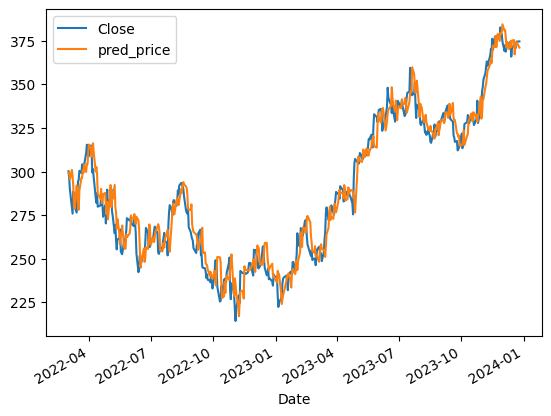

In [75]:
target_raw = stk_data.loc[test_loader.dataset.X.index.values].xs(_TARGET_STK, axis=1, level=1)
# print(target_raw)
target_raw = target_raw.drop(target_raw.index[range(config["seq_len"] - 1)], axis=0)

test_y_pred_df = pd.DataFrame(index=target_raw.index.copy())
test_y_pred_df['pred_price'] = test_y_pred
test_y_pred_df['pred_price'] = (test_y_pred_df['pred_price'] + 1) * target_raw['Close']
test_y_pred_df = test_y_pred_df.shift(config["return_period"])
tmp_data = pd.concat([target_raw, test_y_pred_df], axis=1).dropna()
tmp_data['Close'].plot()
tmp_data['pred_price'].plot()
pyplot.legend()
pyplot.show()
